# Visualizing Text with spaCy and other NLP packages

## This talk: a tasting menu of Python packages for visualizing text

<img src="http://www.theperfectspotsf.com/wp02/wp-content/uploads/2018/06/DOSA-on-Fillmore-Kerala-Tasting-Menu-Copyright-Virginia-Miller.jpg" alt="platter" width="400"/>

## spaCy and other NLP libraries

[spaCy](https://spacy.io/) is a free, open-source library for advanced Natural Language Processing (NLP) in Python. It’s designed specifically for production use and helps you build applications that process and “understand” large volumes of text. It can be used to build information extraction or natural language understanding systems. spaCy is created by [Explosion](https://explosion.ai/). Explosion also makes [Prodigy](https://prodi.gy/), which is a scriptable annotation tool for creating training and evaluation data for machine learning.

This tutorial won't have enough time to go through everything about spaCy -- instead, I'll show you a few examples and also provide some helpful visualizer tools that are part of spaCy's universe. Along the way, I'll introduce you to several of Python's most popular visualization tools like Matplotlib, plotly, Altair, and bokeh.

If you're interested in learning more about spaCy, I recommend spaCy's [free online course](https://course.spacy.io/en) as well as its [spaCy 101 documentation](https://spacy.io/usage/spacy-101). If you're also interested in learning more about Python, I highly recommend [calmcode.io](), which has a ton of free/helpful videos on many Python and related tools.

Be sure to check out the [README](README.md) on instructions on setting up the environment to run this notebook.

In [1]:
import spacy

nlp = spacy.load("en_core_web_sm")
text = "Roads? Where we’re going we don’t need roads!"
doc = nlp(text)

for token in doc:
    print(token)

Roads
?
Where
we
’re
going
we
do
n’t
need
roads
!


In [2]:
doc = nlp("All aboard! \t Train NXH123 departs from platform 22 at 3:16 sharp.")

for token in doc:
    print(token, token.is_space, token.is_punct, token.is_upper, token.is_digit)

All False False False False
aboard False False False False
! False True False False
	  True False False False
Train False False False False
NXH123 False False True False
departs False False False False
from False False False False
platform False False False False
22 False False False True
at False False False False
3:16 False False False False
sharp False False False False
. False True False False


In [3]:
text = "Joe Biden is the president of the United States."
doc = nlp(text)

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Joe Biden PERSON
the United States GPE


spaCy also comes with [Displacy](https://spacy.io/usage/visualizers), which are custom visualizers for spaCy components. 

In [12]:
from spacy import displacy

displacy.render(doc, style="ent", jupyter=True)

In [13]:
# other components in the en_core_web_sm pipeline: https://spacy.io/usage/processing-pipelines
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

For example, the 'parser' is a dependency parser of [parts-of-speech](https://spacy.io/usage/linguistic-features#pos-tagging).

In [14]:
displacy.render(doc, style="dep", jupyter=True)

<div class="alert alert-block alert-info">
<b>Question:</b> How could you use part-of-speech tags to enhance "keyword" searches? </div> 

[Hint](https://www.youtube.com/watch?v=WnGPv6HnBok)

As a dataset, we'll use 1,000 documents from the [Yelp reviews](https://huggingface.co/datasets/yelp_review_full) from the Huggingface `datasets` package.

In [15]:
import pandas as pd

df = pd.read_csv("ready.csv")

# list comprehension: see https://calmcode.io/comprehensions/introduction.html
texts = [_ for _ in df['text']]
print("This list has %s documents" % len(texts))
texts[0]

This list has 1000 documents


"dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."

In [16]:
# textacy has many helper functions with spaCy https://textacy.readthedocs.io/en/0.12.0/index.html
import textacy 
corpus = textacy.Corpus("en_core_web_sm", data=texts[0:100]) # let's only do 100 docs
word_counts = corpus.word_counts(by="lemma_")
top20 = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:20]
top20

[('good', 89),
 ('place', 76),
 ('order', 50),
 ('time', 49),
 ('food', 49),
 ('like', 45),
 ('come', 41),
 ('go', 40),
 ('look', 35),
 ('great', 35),
 ('service', 33),
 ('try', 31),
 ('eat', 30),
 ('want', 29),
 ('say', 29),
 ('ask', 28),
 ('meal', 28),
 ('know', 27),
 ('get', 27),
 ('fish', 27)]

We can then use a wordcloud along with [Matplotlib](https://matplotlib.org/) ([calmcode](https://calmcode.io/matplotlib/introduction.html)), one of the most popular Python data visualization packages. 

For more background on word clouds in Vis research, see [Felix, Franconeri, and Bertini, 2018 TVCG](https://visualthinking.psych.northwestern.edu/publications/BertiniWordClouds2018.pdf).

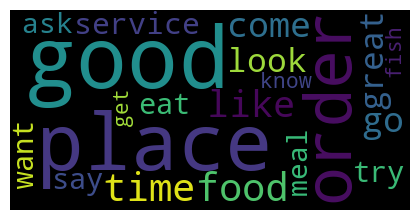

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud().generate_from_frequencies(dict(top20))
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

## Topic modeling with BERTopic

Analyzing new text datasets is challenging because it's hard to know what is the right question to ask. This is where exploratory analysis can help. A popular NLP technique for exploratory analysis is [topic modeling](https://en.wikipedia.org/wiki/Topic_model).

Topic modeling is (typically) is set up as unsupervised machine learning where the goal is to find hidden or latent patterns in datasets that can be interpreated as topics.

We'll use a more modern version of topic modeling using [BERTopic](https://maartengr.github.io/BERTopic/index.html), focusing on its [visualization plots](https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html) which use [plotly](https://plotly.com/).

See [BERTopic's docs](https://maartengr.github.io/BERTopic/algorithm/algorithm.html) for its algorithm.

In [18]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP

# Prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(texts, show_progress_bar=False)
embeddings[0]

array([ 4.55545560e-02, -5.26863672e-02,  4.64571230e-02, -3.06689441e-02,
       -1.33371383e-01, -1.82324369e-02, -4.81083198e-03,  4.85709719e-02,
       -7.60084717e-03, -7.56111071e-02, -5.84672168e-02,  4.37341630e-02,
       -6.55654892e-02,  8.77950191e-02, -2.07908582e-02,  1.03630191e-02,
        1.05165362e-01, -2.44439654e-02,  3.22870282e-03, -2.01619714e-02,
       -5.17249964e-02,  1.60219464e-02,  2.39714384e-02,  2.14622226e-02,
       -3.03224027e-02, -7.18394592e-02, -2.74127014e-02, -1.23539381e-01,
        2.86673885e-02, -4.26325772e-04, -3.08954390e-03, -2.17132620e-03,
       -1.53531190e-02, -5.71619272e-02,  5.80345243e-02,  7.35107437e-02,
        2.23500822e-02,  6.57432377e-02, -9.96270478e-02,  7.06763715e-02,
       -4.62817512e-02,  5.29166237e-02,  9.06415880e-02,  3.14546525e-02,
        3.36336344e-03, -9.26698968e-02, -2.58785533e-03,  2.49082670e-02,
        4.66802232e-02, -1.53027494e-02, -8.62380788e-02, -9.21011120e-02,
        3.95844653e-02, -

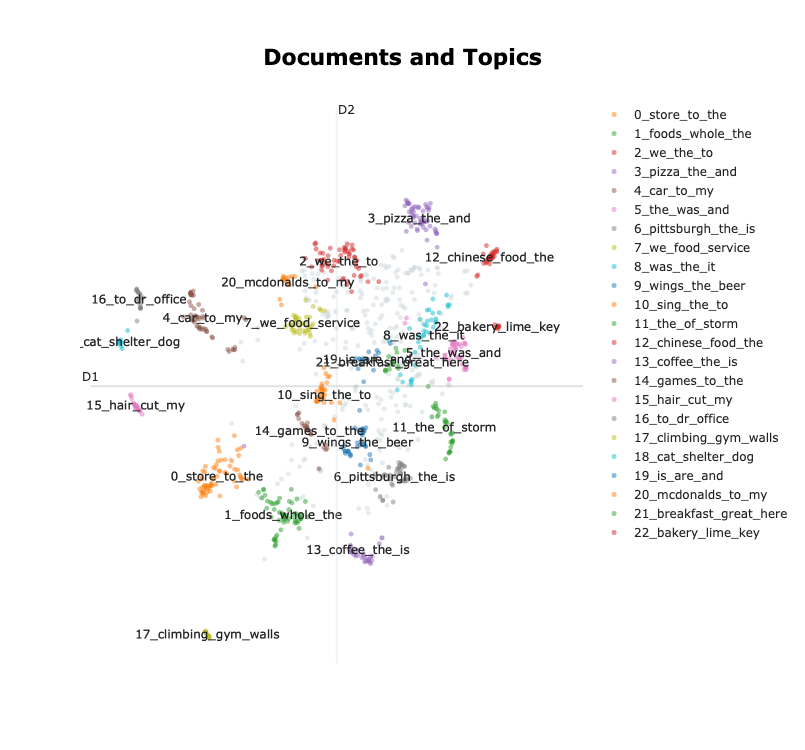

In [ ]:
# Train BERTopic
topic_model = BERTopic().fit(texts, embeddings)

# Run the visualization with the original embeddings
topic_model.visualize_documents(texts, embeddings=embeddings)

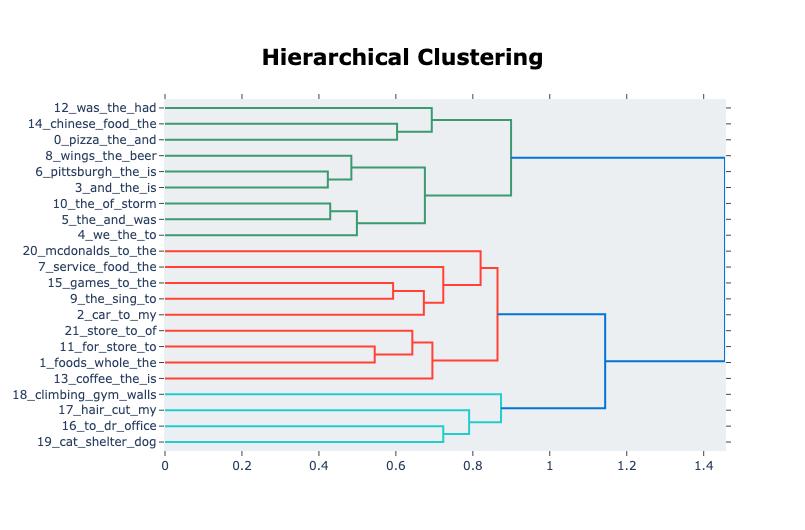

In [ ]:
topic_model.visualize_hierarchy()

For more details, check out [Jay Alammar](https://jalammar.github.io/) and Cohere's great tutorial on BERTopic:

In [19]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/uZxQz87lb84" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## `whatlies`

A major advance in NLP over the last 10 years has been [word embedding models](https://ruder.io/word-embeddings-1/). These provide a way to quantify word meaning. Embeddings are typically "pre-trained" by learning the context of words that tend to co-occur. A classic example is [word2vec](https://jalammar.github.io/illustrated-word2vec/). One example is [Tensorboard Projector](https://projector.tensorflow.org/).

The [`whatlies`](https://github.com/koaning/whatlies) package tries to help you to understand: "What lies in word embeddings?". It is created by [Vincent Warmerdam](https://koaning.io/whois/) and colleagues.

This small library offers tools to make visualisation easier of both word embeddings as well as operations on them. This should be considered an experimental project. This library will allow you to make visualisations of transformations of word embeddings. Some of these transformations are linear algebra operators.

The library uses [`altair`](https://altair-viz.github.io/), which is a Python package for [Vega-Lite](https://vega.github.io/vega-lite/). 

In [20]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/UwAvyACOrWs" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [21]:
from whatlies import EmbeddingSet
from whatlies.language import SpacyLanguage

lang = SpacyLanguage("en_core_web_md")
words = ["cat", "dog", "fish", "kitten", "man", "woman",
         "king", "queen", "doctor", "nurse"]

emb = EmbeddingSet(*[lang[w] for w in words])
emb.plot_interactive(x_axis=emb["man"], y_axis=emb["woman"])

alt.LayerChart(...)

You can perform these on embeddings as well as sets of embeddings. In the example below we attempt to filter away gender bias using linear algebra operations.

In [ ]:
orig_chart = emb.plot_interactive('man', 'woman')

new_ts = emb | (emb['king'] - emb['queen'])
new_chart = new_ts.plot_interactive('man', 'woman')

new_chart

alt.LayerChart(...)

## `bulk`

[`bulk`](https://github.com/koaning/bulk) is a quick developer tool to apply some bulk labels. Given a prepared dataset with 2d embeddings it can generate an interface that allows you to quickly add some bulk, albeit less precice, annotations.

This is very related to the idea of visual interactive labeling (see [Bernard et al., 2017 TVCG](https://www.vis.uni-stuttgart.de/documentcenter/staff/sedlmaml/papers/bernard2017labeling.pdf)).

In [ ]:
import pandas as pd
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LogisticRegression
from umap import UMAP

# pip install "embetter[text]"
from embetter.text import SentenceEncoder

# Build a sentence encoder pipeline with UMAP at the end.
text_emb_pipeline = make_pipeline(
  SentenceEncoder('all-MiniLM-L6-v2'),
  UMAP()
)

# Calculate embeddings 
X_tfm = text_emb_pipeline.fit_transform(texts)

# Write to disk. Note! Text column must be named "text"
df = pd.DataFrame({"text": texts})
df['x'] = X_tfm[:, 0]
df['y'] = X_tfm[:, 1]
df.to_csv("ready.csv")

In [22]:
!python -m bulk text ready.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
About to serve `bulk` over at http://localhost:5006/.
404 GET /favicon.ico (::1) 0.23ms
^C

Aborted!


In [25]:
!python -m bulk text ready.csv --keywords "coffee,pizza,wings,Chinese"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
About to serve `bulk` over at http://localhost:5006/.
^C

Aborted!


If you're interested in learning more, check out Vincent's [Bulk Labeling and Prodigy video](https://www.youtube.com/embed/gDk7_f3ovIk) or the related video on [Bulk Labeling for Images](https://www.youtube.com/watch?v=DmH3JmX3w2I&feature=emb_rel_pause).